In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset
import experiments_utils

Set cells width

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [6]:
INPUT_PATH = "../../data/email-Eu-core-temporal.txt.gz"

Load the dataset

In [7]:
dataset = Dataset(INPUT_PATH, top=100, timescale='median')
#dataset = Dataset.from_pickle(INPUT_PATH)

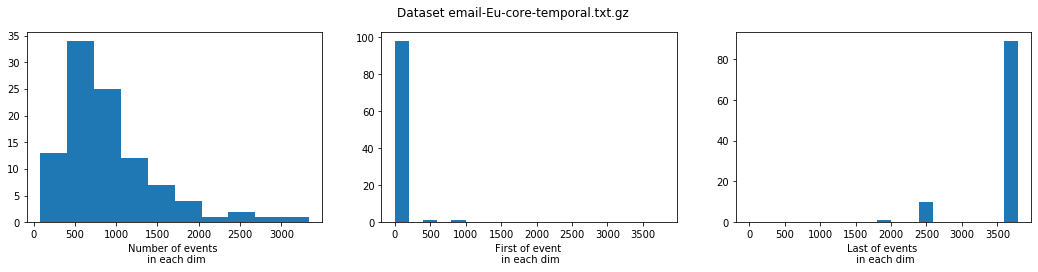

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

axs[0].hist(list(map(len, dataset.timestamps)))
axs[0].set_xlabel('Number of events \n in each dim')

end_time = dataset.end_time
axs[1].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[1].set_xlabel('First of event \n in each dim')

axs[2].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_xlabel('Last of events \n in each dim')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}");

Print statistics of the dataset

In [9]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 100
    Num. of events: 92,924
               %NZ: 26.23%

Stats. of num. of events per dim:
count     100.000000
mean      929.240000
std       589.331261
min        82.000000
25%       544.000000
50%       770.000000
75%      1210.000000
max      3334.000000
dtype: float64


Build ground truth adjacency matrix

In [10]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodelist=range(dataset.dim)).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

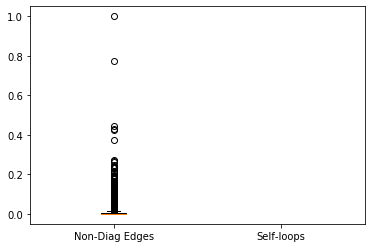

In [11]:
diag_mask = np.eye(len(adjacency_true)).astype(bool)
plt.boxplot([adjacency_true[~diag_mask & (adjacency_true > 0)], adjacency_true[diag_mask & (adjacency_true > 0)]],
            labels=['Non-Diag Edges', 'Self-loops']);

#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    100.000000
mean       1.047821
std        1.697593
min        0.027073
25%        0.290703
50%        0.556093
75%        0.916578
max       13.945126
dtype: float64

Busca estimators of **beta_{ji}**:
count    10000.000000
mean         1.218508
std          2.322191
min          0.000000
25%          0.344152
50%          1.004831
75%          1.474058
max        118.573898
dtype: float64



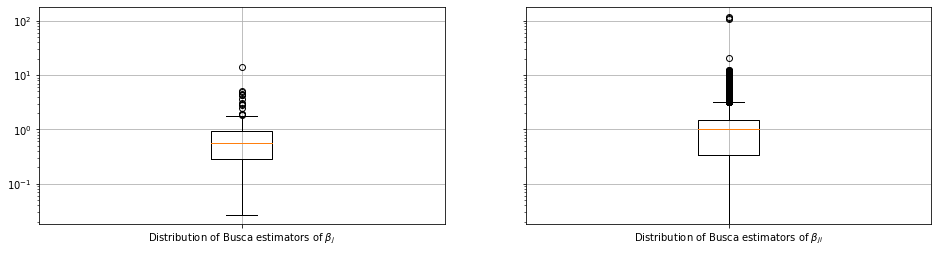

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) for ev in dataset.timestamps])
plt.sca(axs[0])
plt.grid()
plt.boxplot(busca_betas, labels=[r'Distribution of Busca estimators of $\beta_j$']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print()

wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
del wold_model
plt.sca(axs[1])
plt.grid()
plt.boxplot(busca_beta_ji.flatten(), labels=[r'Distribution of Busca estimators of $\beta_{ji}$']);
plt.yscale('log')
print('Busca estimators of **beta_{ji}**:')
print(pd.Series(busca_beta_ji.flatten()).describe())
print()

In [13]:
events = dataset.timestamps
end_time = dataset.end_time

---

## Run inference

---

### Run BBVI

In [ ]:
dim = len(events)
n_params = dim + dim**2 + dim**2
end_time = max(map(max, events))

# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    # loc
    -2.0 * torch.ones(dim, dtype=torch.float),                  # baseline
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # beta
    -2.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # adjacency
    # scale
    torch.log(0.2 * torch.ones(dim, dtype=torch.float)),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
)))

# Define priors/posteriors
posterior = tsvar.posteriors.LogNormalPosterior
prior = tsvar.priors.GaussianLaplacianPrior
mask_gaus = torch.zeros(n_params, dtype=torch.bool)
mask_gaus[:dim + dim**2] = 1  # Gaussian prior for baseline and beta
C = 1e3

# Init the model object
model = tsvar.models.WoldModelBBVI(posterior=posterior, prior=prior, C=C,
                                   prior_kwargs={'mask_gaus': mask_gaus},
                                   n_samples=1, n_weights=1, weight_temp=1,
                                   verbose=False, device='cpu')
model.observe(events, end_time)

# Set link function for callback (vi coeffs -> posterior mode)
def link_func(coeffs):
    """variationa coeffs -> posterior mode of adjacency"""
    # Numpy to torch
    coeffs = torch.tensor(coeffs) if isinstance(coeffs, np.ndarray) else coeffs
    return model.posterior.mode(
        coeffs[:model.n_params], coeffs[model.n_params:]
    ).detach().numpy()[dim:dim+dim**2]

# Set the callback (callback parameters are posterior mode)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=posterior().mode(
        coeffs_start[:dim+2*dim**2], coeffs_start[dim+2*dim**2:]
    )[dim:dim+dim**2],
    print_every=100,
    coeffs_true=adjacency_true,
    acc_thresh=0.05,
    dim=dim,
    link_func=link_func,
    default_end='\n')

# Fit the model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=1e-1,
                 lr_sched=0.9999, tol=1e-6, max_iter=20000,
                 mstep_interval=100, mstep_offset=500, mstep_momentum=0.5,
                 seed=None, callback=callback)

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

In [ ]:
plt.boxplot([adj_hat.flatten(), beta_hat.flatten()]);

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

adj_hat = adj_hat / beta_hat

experiments_utils.print_report(adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.05)

---

### Run VI

In [15]:
dim = len(events)

# Set priors
# prior: Alpha
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 110.0 * np.ones((dim, dim))
br_pr = 100.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.1
variance
0.1
BETA:
-----
mean
0.9174311926605505
variance
0.0077933332709866675


In [16]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(events)

In [18]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=1,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=50, tol=1e-5, callback=callback)

a_mean: min:+2.41e-04, max:+1.25e-01
b_mean: min:+8.99e-01, max:+1.08e+00
iter:     1 | dx: +9.9672e-02 | f1-score: 0.00 | relerr: 1.76e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 2.19e+01     
a_mean: min:+2.56e-04, max:+1.42e-01
b_mean: min:+8.49e-01, max:+9.65e-01
iter:     2 | dx: +5.9534e-02 | f1-score: 0.00 | relerr: 1.87e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 1.49e+01     
a_mean: min:+9.23e-05, max:+2.27e-01
b_mean: min:+7.94e-01, max:+9.54e-01
iter:     3 | dx: +8.5466e-02 | f1-score: 0.01 | relerr: 1.93e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.00 | time/it: 1.52e+01     
a_mean: min:+5.26e-05, max:+3.45e-01
b_mean: min:+7.27e-01, max:+9.60e-01
iter:     4 | dx: +1.1786e-01 | f1-score: 0.02 | relerr: 2.01e+01 | p@5: 0.00 | p@10: 0.00 | p@20: 0.10 | time/it: 1.50e+01     
a_mean: min:+4.18e-05, max:+4.89e-01
b_mean: min:+6.57e-01, max:+9.63e-01
iter:     5 | dx: +1.4399e-01 | f1-score: 0.03 | relerr: 2.07e+01 | p@5: 0.00 | p@10: 0.10 | p@20: 0.10 | time/it:

KeyboardInterrupt: 

In [39]:
mu_hat = vi_model._as_po[0, :] / vi_model._ar_po[0, :]
adj_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1
model_name = type(vi_model).__name__

#adj_hat = adj_hat
adj_hat = adj_hat / beta_hat

diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
adjacency_true_zero_diag = adjacency_true.copy()
adjacency_true_zero_diag[diag_mask] = 0
#adj_hat[diag_mask] = 0


experiments_utils.print_report(name=type(vi_model).__name__, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.01)


========== Method: WoldModelVariational

Accuracy: 0.69

Edge counts
------------
Pred: 979.00
True: 2623.00

Error counts
------------
 True Positive: 255.00
False Positive: 724.00
 True Negative: 6653.00
False Negative: 2368.00

Error rates
-----------
 True Positive Rate: 0.10
False Positive Rate: 0.10
 True Negative Rate: 0.90
False Negative Rate: 0.90

F-Score
-------
 F1-Score: 0.14
Precision: 0.26
   Recall: 0.10

Precision@k
-----------
 Prec@5: 0.20
Prec@10: 0.30
Prec@20: 0.35

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.09494949494949494
10 0.1454545454545453
20 0.2202020202020202



In [18]:
print('as nan:', np.isnan(vi_model._as_po).any())
print('ar nan:', np.isnan(vi_model._ar_po).any())
print('bs nan:', np.isnan(vi_model._bs_po).any())
print('br nan:', np.isnan(vi_model._br_po).any())
print('bs < 0:', np.any(vi_model._bs_po < 0))
print('br < 0:', np.any(vi_model._br_po < 0))
print('x0 < 0:', np.any(vi_model._b_x0 < 0))
print('xn < 0:', np.any(vi_model._b_xn < 0))
print('x0 inf:', np.any(vi_model._b_x0 > 1e10))
print('xn inf:', np.any(vi_model._b_xn > 1e10))

as nan: False
ar nan: False
bs nan: False
br nan: False
bs < 0: False
br < 0: False
x0 < 0: False
xn < 0: False
x0 inf: False
xn inf: False


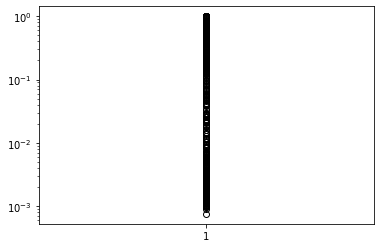

In [22]:
plt.boxplot(adj_hat.flatten());
plt.yscale('log');

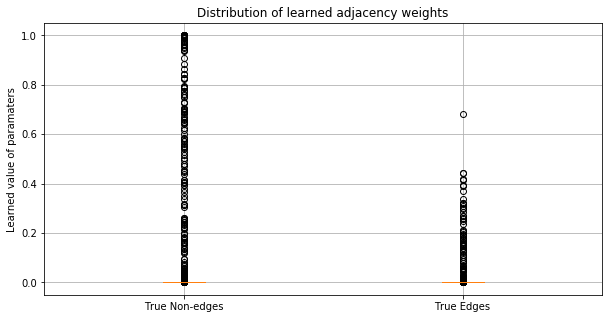

In [23]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [adj_hat[adjacency_true == 0.0], adj_hat[adjacency_true > 0.0]],
    labels=['True Non-edges', 'True Edges'])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

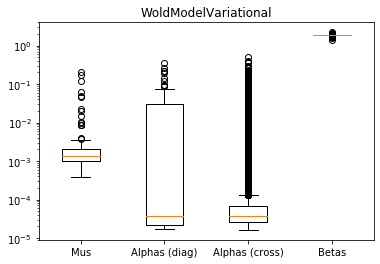

In [40]:
diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
plt.boxplot([mu_hat.flatten(), adj_hat[diag_mask].flatten(), adj_hat[~diag_mask].flatten(), beta_hat.flatten()], 
            labels=['Mus', 'Alphas (diag)', 'Alphas (cross)', 'Betas']);
plt.yscale('log');
plt.title(model_name);

---

### Run GB

In [45]:
import gb
import time

dim = len(events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=3000,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=4,
)
granger_model.fit(events)

In [46]:
# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))
model_name = type(granger_model).__name__

#adj_hat = adj_hat / beta_hat  # Does not matter

diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
adjacency_true_zero_diag = adjacency_true.copy()
adjacency_true_zero_diag[diag_mask] = 0
#adj_hat[diag_mask] = 0


THRESH = 0.00  # GB is already sparse

experiments_utils.print_report(name=model_name, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0)


========== Method: GrangerBusca

Accuracy: 0.26

Edge counts
------------
Pred: 518.00
True: 2623.00

Error counts
------------
 True Positive: 173.00
False Positive: 345.00
 True Negative: 7032.00
False Negative: 2450.00

Error rates
-----------
 True Positive Rate: 0.07
False Positive Rate: 0.05
 True Negative Rate: 0.95
False Negative Rate: 0.93

F-Score
-------
 F1-Score: 0.11
Precision: 0.33
   Recall: 0.07

Precision@k
-----------
 Prec@5: 0.00
Prec@10: 0.00
Prec@20: 0.00

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.2686868686868685
10 0.27979797979797977
20 0.20707070707070707



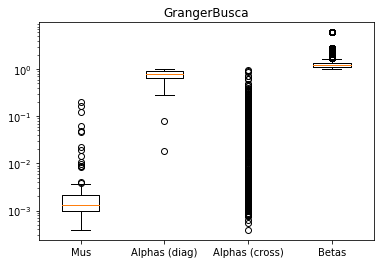

In [47]:
diag_mask = np.eye(adj_hat.shape[0]).astype(bool)
plt.boxplot([mu_hat.flatten(), adj_hat[diag_mask].flatten(), adj_hat[~diag_mask].flatten(), beta_hat.flatten()], 
            labels=['Mus', 'Alphas (diag)', 'Alphas (cross)', 'Betas']);
plt.yscale('log');
plt.title(model_name);

In [161]:
tsvar.utils.metrics.relerr(adj_hat.flatten(), adjacency_true.flatten(), null_norm='none')

0.7420330871354197

In [180]:
scipy.stats.kendalltau(adj_hat.flatten(), adjacency_true.flatten())

KendalltauResult(correlation=-0.03233722944985986, pvalue=0.0005001328376041202)

In [166]:
tsvar.utils.metrics.mean_kendall_rank_corr(adj_hat.flatten(), adjacency_true.flatten())

-0.039862506938532154

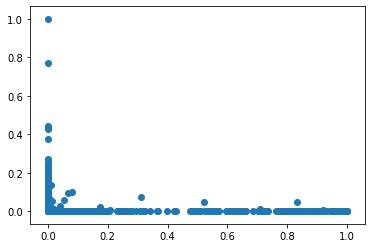

In [167]:
plt.scatter(adj_hat.flatten(), adjacency_true.flatten())

In [181]:
mean_rank_corr, rank_corr_per_dim = tsvar.utils.metrics.mean_kendall_rank_corr(
    adj_hat.flatten(), adjacency_true.flatten(), return_vec=True)

In [182]:
mean_rank_corr

-0.039862506938532154

(array([ 6., 17., 24., 15., 12.,  7.,  8.,  4.,  3.,  4.]),
 array([-0.16471, -0.13208, -0.09946, -0.06683, -0.0342 , -0.00158,  0.03105,  0.06367,  0.0963 ,  0.12893,  0.16155]),
 <a list of 10 Patch objects>)

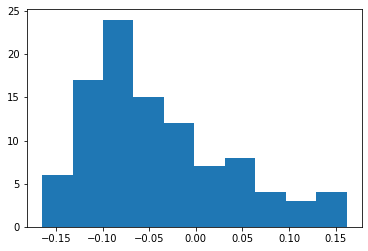

In [183]:
plt.hist(rank_corr_per_dim)

In [172]:
from scipy.stats import kendalltau

# calculate kendall's correlation
coef, p = kendalltau(
    x=adj_hat.flatten(),
    y=adjacency_true.flatten()
)

print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

Kendall correlation coefficient: -0.032
Samples are correlated (reject H0) p=0.001


---

## Exploration of results

In [167]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]
adj_hat

array([[0.00141, 0.00181, 0.00855, ..., 0.00943, 0.00923, 0.01304],
       [0.00311, 0.00129, 0.01251, ..., 0.00915, 0.00726, 0.01185],
       [0.00343, 0.00186, 0.04852, ..., 0.0099 , 0.00796, 0.01432],
       ...,
       [0.02883, 0.01501, 0.01245, ..., 0.00958, 0.01153, 0.02437],
       [0.01216, 0.00995, 0.00887, ..., 0.03078, 0.01442, 0.02328],
       [0.00137, 0.00276, 0.00194, ..., 0.0191 , 0.01991, 0.01562]])

In [168]:
adj_hat.nonzero()

(array([  0,   0,   0, ..., 622, 622, 622]),
 array([  0,   1,   2, ..., 620, 621, 622]))

In [170]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

thresh_list = np.linspace(0.01, 0.15, 20)

vals_vifb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0
    print(np.round(thresh, 3), len(adj_hat_thresh.nonzero()[0]))

    for k in [5, 10, 20]:
        vals_vifb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

0.01 68288
0.017 31004
0.025 17360
0.032 11503
0.039 8389
0.047 6450
0.054 5161
0.062 4092
0.069 3304
0.076 2612
0.084 2068
0.091 1641
0.098 1313
0.106 912
0.113 804
0.121 720
0.128 658
0.135 604
0.143 551
0.15 516


In [159]:
thresh_list = np.linspace(0.01, 0.15, 20)

vals_gb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0

    for k in [5, 10, 20]:
        vals_gb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

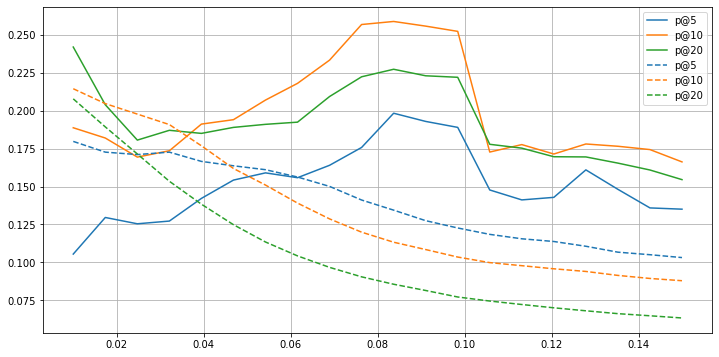

In [161]:
plt.figure(figsize=(12, 6))
plt.grid()

plt.plot(thresh_list, vals_vifb[5], label='p@5')
plt.plot(thresh_list, vals_vifb[10], label='p@10')
plt.plot(thresh_list, vals_vifb[20], label='p@20')

plt.plot(thresh_list, vals_gb[5],   label='p@5', c='C0', ls='--')
plt.plot(thresh_list, vals_gb[10], label='p@10', c='C1', ls='--')
plt.plot(thresh_list, vals_gb[20], label='p@20', c='C2', ls='--')

plt.legend();